In [20]:
import re
import numpy as np
import albumentations
from torch.utils.data import Dataset

def read_pfm(filename):
    file = open(filename, 'rb')
    color = None
    width = None
    height = None
    scale = None
    endian = None

    header = file.readline().decode('utf-8').rstrip()
    if header == 'PF':
        color = True
    elif header == 'Pf':
        color = False
    else:
        raise Exception('Not a PFM file.')

    dim_match = re.match(r'^(\d+)\s(\d+)\s$', file.readline().decode('utf-8'))
    if dim_match:
        width, height = map(int, dim_match.groups())
    else:
        raise Exception('Malformed PFM header.')

    scale = float(file.readline().rstrip())
    if scale < 0:  # little-endian
        endian = '<'
        scale = -scale
    else:
        endian = '>'  # big-endian

    data = np.fromfile(file, endian + 'f')
    shape = (height, width, 3) if color else (height, width)

    data = np.reshape(data, shape)
    data = np.flipud(data)
    file.close()
    return data, scale

def read_depth(filename):
    # read pfm depth file
    return np.array(read_pfm(filename)[0], dtype=np.float32)

class DepthPaths(Dataset):
    def __init__(self, paths, size=None, random_crop=False, max_depth=None):
        self.size = size
        self.random_crop = random_crop

        self.file_paths = paths
        self._length = len(paths)

        if self.size is not None and self.size > 0:
            self.rescaler = albumentations.SmallestMaxSize(max_size=self.size)
            if not self.random_crop:
                self.cropper = albumentations.CenterCrop(height=self.size, width=self.size)
            else:
                self.cropper = albumentations.RandomCrop(height=self.size, width=self.size)
            self.preprocessor = albumentations.Compose([self.rescaler, self.cropper])
        else:
            self.preprocessor = lambda **kwargs: kwargs

        if max_depth is not None:
            self.max_depth = max_depth 
        else:
            raise AttributeError("max_depth should be defined.")

    def __len__(self):
        return self._length

    def preprocess_depth(self, depth_path):
        depth = read_depth(depth_path)
        if len(depth.shape) == 2:  # if the depth map is only one channel
            depth = np.expand_dims(depth, axis=2)
        depth_image = np.array(depth).astype(np.float32)
        depth_image = self.preprocessor(image=depth_image)["image"]
        # Normalize the depth values to (-1, 1)
        # This normalization step is dependent on the specifics of your depth data
        depth_image = ((depth_image / (self.max_depth / 2)) - 1.0).astype(np.float32)
        return depth_image

    def __getitem__(self, index):
        depth_path = self.file_paths[index]
        depth_image = self.preprocess_depth(depth_path)
        return depth_image


In [21]:
with open('train.txt', 'r') as file:
    paths = [line.strip() for line in file]

In [22]:
dataset = DepthPaths(paths, size=512, max_depth=1218.31)

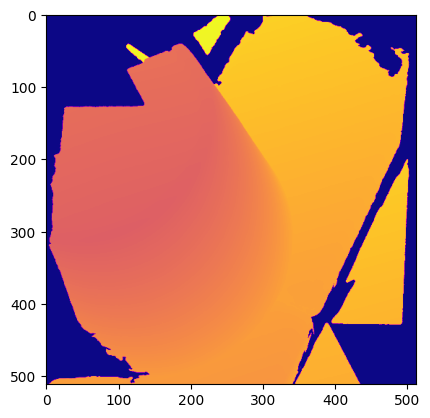

In [26]:
import matplotlib.pyplot as plt

plt.imshow(dataset[0], cmap='plasma')

In [27]:
dataset[0].shape

(512, 512, 1)